# Data prep (legacy)

NB this is superceeded by 01_data_prep_rasterio.py




# Pre-Processing

use conda env 'solaris'

Run this notebook for each dataset by changing:

<pre>
COUNTRY='st_lucia'
REGION='gros_islet'
DATASET_PATH=st_lucia_gros_islet
</pre>

For each country and region

In [199]:
# for bleeding edge version of solaris:
# !pip install git+https://github.com/CosmiQ/solaris/@dev

In [200]:
import solaris as sol
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
from pathlib import Path
import rasterio
import os
import skimage
from tqdm import tqdm
import pandas as pd

import fiona
import numpy as np

from rasterstats.io import Raster
from PIL import Image

from rio_tiler import main as rt_main
# import mercantile
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import mapping
from rasterio.transform import from_bounds
from shapely.geometry import Polygon as shapely_polygon
from shapely.ops import cascaded_union

### can run all from here

In [201]:
tile_size = 256
zoom_level = 21

In [202]:
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [203]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [204]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [205]:
data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

In [206]:
#for pth in ['colombia_borde_rural', 'colombia_borde_soacha', 'guatemala_mixco_1', 'guatemala_mixco_3',
#         'st_lucia_castries','st_lucia_dennery', 'st_lucia_gros_islet']:
#    img_path = data_dir/f'{pth}_images-{tile_size}'
#    mask_path = data_dir/f'{pth}_masks-{tile_size}'
#    img_path.mkdir(exist_ok=True)
#    mask_path.mkdir(exist_ok=True)

### main vars to set

In [207]:
COUNTRY='colombia'
REGION='borde_rural'

In [208]:
DATASET_PATH=colombia_rural

### run all from here

In [209]:
DATASET = f'{COUNTRY}_{REGION}'

In [210]:
#no test data for these
test_exists=True
if REGION in ['castries','gros_islet']:
    test_exists=False

In [211]:
DATA_TIFF = DATASET_PATH/f'{REGION}_ortho-cog.tif'
TRAIN_JSON = f'train-{REGION}.geojson'
TRAIN_TRN_JSON = f'train-{REGION}_trn.geojson'
TRAIN_VAL_JSON = f'train-{REGION}_val.geojson'
TEST_JSON = f'test-{REGION}.geojson'
PNG_THUMBNAL = DATASET_PATH/f'{REGION}_ortho-cog-thumbnail.png'

In [212]:
img_path=data_dir/f'{DATASET}_images-{tile_size}'
img_path

PosixPath('data/colombia_borde_rural_images-256')

In [213]:
mask_path=data_dir/f'{DATASET}_masks-{tile_size}'

In [214]:
rasterio.open(DATA_TIFF).meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 31315,
 'height': 52318,
 'count': 4,
 'crs': CRS.from_epsg(32618),
 'transform': Affine(0.03944, 0.0, 592371.56518,
        0.0, -0.03944, 503768.46364000003)}

In [215]:
# load geojson colombia rural training data

label_df = gpd.read_file(DATASET_PATH/TRAIN_JSON)
label_df = label_df[label_df['geometry'].isna() != True] # remove empty rows

In [216]:
label_df.crs

{'init': 'epsg:4326'}

In [217]:
epsg=str(rasterio.open(DATA_TIFF).meta['crs']).split(':')[1]

In [218]:
label_df = label_df.to_crs({'init': f'epsg:{epsg}'}) 

In [219]:
label_df.crs

{'init': 'epsg:32618'}

In [220]:
label_df.head()

,id,roof_material,verified,geometry
0,7a3f2a10,concrete_cement,True,"POLYGON ((593322.0146307958 503544.0120043904,..."
1,7a1f731e,irregular_metal,True,"POLYGON ((593314.707898139 503546.9842346236, ..."
2,7a424ad8,healthy_metal,True,"POLYGON ((593310.1257098615 503552.8048521634,..."
3,7a3edc5e,healthy_metal,True,"POLYGON ((593287.5862972594 503498.5616504047,..."
4,7a303a6e,healthy_metal,True,"POLYGON ((593310.1257098617 503527.4170522558,..."


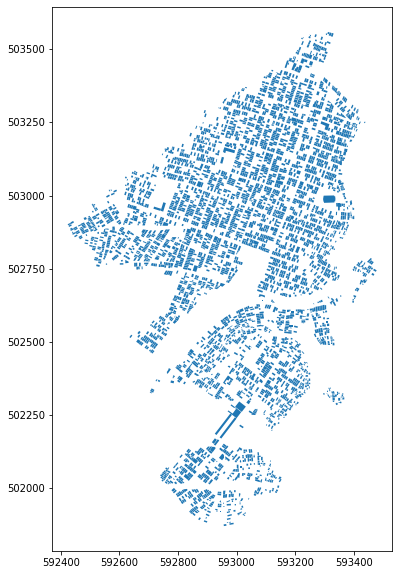

In [221]:
label_df.plot(figsize=(10,10))

{'init': 'epsg:4326'}
{'init': 'epsg:32618'}


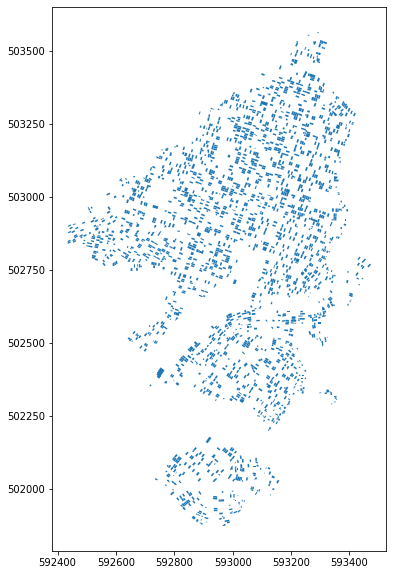

In [222]:
# load geojson test data
if test_exists:
    label_df_test = gpd.read_file(DATASET_PATH/TEST_JSON)
    label_df_test = label_df_test[label_df_test['geometry'].isna() != True] # remove empty rows
    print(label_df_test.crs)
    label_df_test = label_df_test.to_crs({'init': f'epsg:{epsg}'}) 
    print(label_df_test.crs)
    label_df_test.plot(figsize=(10,10))

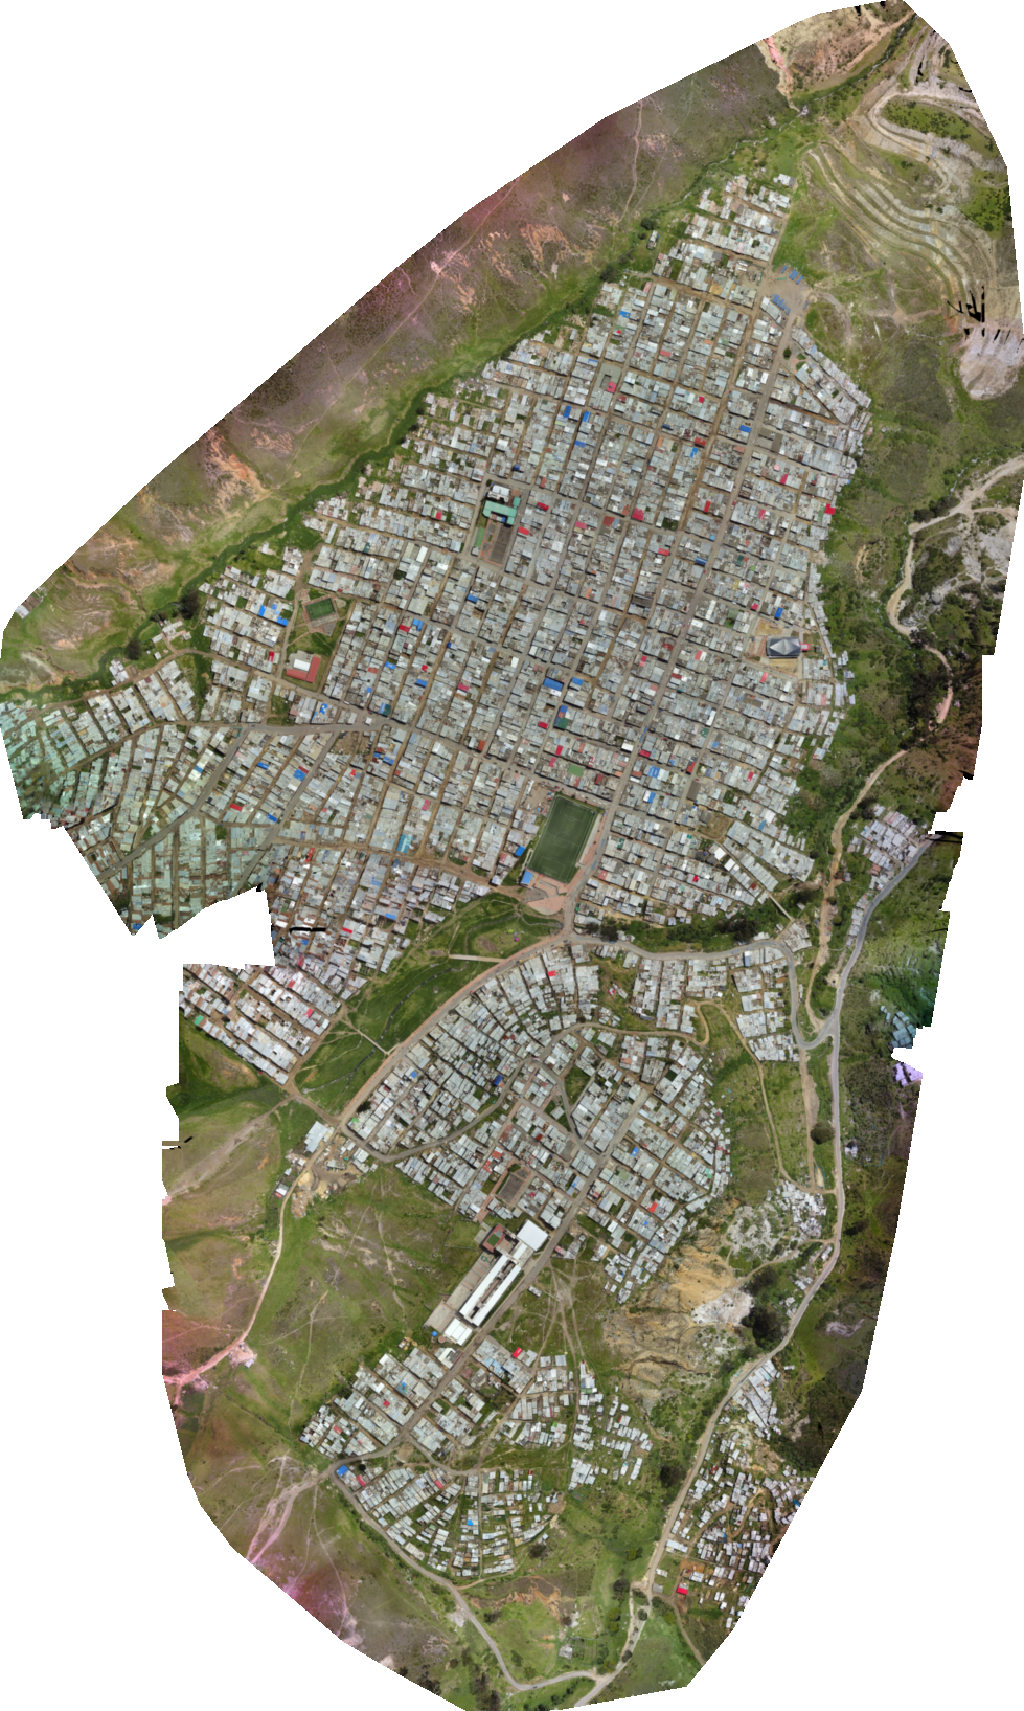

In [223]:
from PIL import Image
path = PNG_THUMBNAL
display(Image.open(path))

In [224]:
label_df.head()

,id,roof_material,verified,geometry
0,7a3f2a10,concrete_cement,True,"POLYGON ((593322.0146307958 503544.0120043904,..."
1,7a1f731e,irregular_metal,True,"POLYGON ((593314.707898139 503546.9842346236, ..."
2,7a424ad8,healthy_metal,True,"POLYGON ((593310.1257098615 503552.8048521634,..."
3,7a3edc5e,healthy_metal,True,"POLYGON ((593287.5862972594 503498.5616504047,..."
4,7a303a6e,healthy_metal,True,"POLYGON ((593310.1257098617 503527.4170522558,..."


In [225]:
len(label_df)

4361

### RasterIO

In [226]:
poly_path = data_dir/f'{COUNTRY}_{REGION}'
poly_path.mkdir(exist_ok=True)
cropped = data_dir/f'{COUNTRY}_{REGION}/cropped'
cropped.mkdir(exist_ok=True)
cropped_trn= data_dir/f'{COUNTRY}_{REGION}/cropped/train'
cropped_trn.mkdir(exist_ok=True)
if test_exists:
    cropped_test= data_dir/f'{COUNTRY}_{REGION}/cropped/test'
    cropped_test.mkdir(exist_ok=True)

In [227]:
def mask_raster(df, tif_filename, save_path, buffer=2):
    with rasterio.open(tif_filename) as src:
        for index, row in label_df.iterrows():
            id = row["id"]
            poly=label_df.iloc[[index]]['geometry']        
            poly=poly.buffer(distance=buffer, cap_style=2, join_style=2)
            out_image, out_transform = rasterio.mask.mask(src, poly, crop=True)
            out_meta = src.meta
            out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
            path_out=data_dir/f'{COUNTRY}_{REGION}/cropped/{save_path}/{id}.tif'
            with rasterio.open(path_out, "w", **out_meta) as dest:
                dest.write(out_image)

7a3f2a10


/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


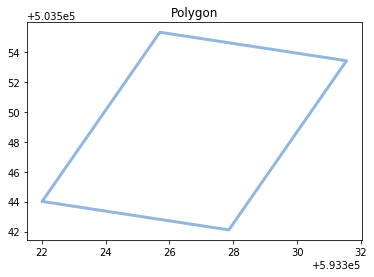

In [228]:
i=0
for row in label_df.itertuples():
    if i<1:
        id = getattr(row, "id")
        print(id)
        poly = getattr(row, "geometry")
        x,y = poly.exterior.xy
        fig=plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x, y, color='#6699cc', alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)
        ax.set_title('Polygon')
        fig.show()
    i+=1

7a3f2a10


/home/walle/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


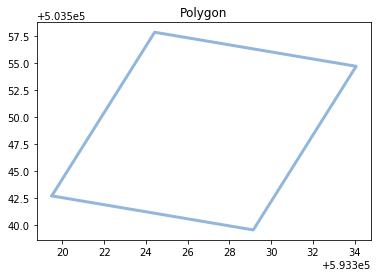

In [229]:
i=0
for row in label_df.itertuples():
    if i<1:
        id = getattr(row, "id")
        print(id)
        poly = getattr(row, "geometry")
        poly=poly.buffer(distance=2, cap_style=2, join_style=2)
        x,y = poly.exterior.xy
        fig=plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x, y, color='#6699cc', alpha=0.7,
                linewidth=3, solid_capstyle='round', zorder=2)
        ax.set_title('Polygon')
        fig.show()
    i+=1

In [ ]:
%%time
mask_raster(label_df, DATA_TIFF, save_path='train', buffer=0.2)

In [ ]:
%%time
if test_exists:
    mask_raster(label_df_test, DATA_TIFF, save_path='test', buffer=0.2)